In [12]:
!pip install clip-benchmark>=1.4.0 datasets>=2.8.0 open-clip-torch>=2.20.0 timm>=0.9.5 coremltools graphviz torchview


In [2]:
#We clone MobileCLIP from: https://github.com/apple/ml-mobileclip
!git clone https://github.com/apple/ml-mobileclip.git

#Install MobileCLIP
%cd ml-mobileclip
!pip install -e . -q

Cloning into 'ml-mobileclip'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 68 (delta 19), reused 65 (delta 16), pack-reused 0
Receiving objects: 100% (68/68), 447.61 KiB | 2.25 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [15]:
#Download pretrained checkpoints
%mkdir -p checkpoints
!wget wget https://docs-assets.developer.apple.com/ml-research/datasets/mobileclip/mobileclip_s0.pt -P checkpoints

--2024-07-09 12:58:28--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unable to resolve host address ‘wget’
--2024-07-09 12:58:28--  https://docs-assets.developer.apple.com/ml-research/datasets/mobileclip/mobileclip_s0.pt
Resolving docs-assets.developer.apple.com (docs-assets.developer.apple.com)... 17.253.117.202, 17.253.117.201, 2403:300:a30:f100::2, ...
Connecting to docs-assets.developer.apple.com (docs-assets.developer.apple.com)|17.253.117.202|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 215934653 (206M) [application/octet-stream]
Saving to: ‘checkpoints/mobileclip_s0.pt’

mobileclip_s0.pt    100%[===================>] 205.93M  52.9MB/s    in 4.2s    

2024-07-09 12:58:32 (49.5 MB/s) - ‘checkpoints/mobileclip_s0.pt’ saved [215934653/215934653]

FINISHED --2024-07-09 12:58:32--
Total wall clock time: 4.7s
Downloaded: 1 files, 206M in 4.2s (49.5 MB/s)


In [16]:
#Model inference with reparamerized model
import coremltools
import torch
import mobileclip
from mobileclip.modules.common.mobileone import reparameterize_model
from mobileclip.modules.text.tokenizer import (
    ClipTokenizer,
)
from mobileclip.clip import CLIP
from typing import Dict, Optional, Any
import json
import os

# mobileclip_s0
model_cfg = {
    "embed_dim": 512,
    "image_cfg": {
        "image_size": 256,
        "model_name": "mci0"
    },
    "text_cfg": {
        "context_length": 77,
        "vocab_size": 49408,
        "dim": 512,
        "ffn_multiplier_per_layer": 4.0,
        "n_heads_per_layer": 8,
        "n_transformer_layers": 4,
        "norm_layer": "layer_norm_fp32",
        "causal_masking": False,
        "model_name": "mct"
    }
}

class CLIP_encode_image(CLIP):
    """Class for encoding images using the image encoder from CLIP."""

    def __init__(self, cfg: Dict, output_dict: bool = False, *args, **kwargs) -> None:
        super().__init__(cfg, output_dict, *args, **kwargs)

    def forward(self, image: Optional[torch.Tensor] = None) -> Any:
        image_embeddings = (
            self.encode_image(image, normalize=True) if image is not None else None
        )
        return image_embeddings


model_ie = CLIP_encode_image(cfg=model_cfg)
model_ie.eval()

chkpt = torch.load("checkpoints/mobileclip_s0.pt")
model_ie.load_state_dict(chkpt)

reparameterized_model = reparameterize_model(model_ie)
reparameterized_model.eval()


image = torch.rand(1, 3, 256, 256)
traced_model = torch.jit.trace(reparameterized_model, image)

# Define the input as an image type
input_image = coremltools.ImageType(name="input_image", shape=(1, 3, 256, 256), color_layout=coremltools.colorlayout.RGB, scale=1/255.0, bias=[0, 0, 0])


ml_model = coremltools.convert(
        model=traced_model,
        outputs=None,
        inputs=[input_image],
        convert_to="mlprogram",
        minimum_deployment_target=coremltools.target.iOS17,
        compute_units=coremltools.ComputeUnit.ALL,
        debug=True,
    )
ml_model.save("clip_mci_image_s0.mlpackage")

Running MIL default pipeline:  12%|█▏        | 9/78 [00:00<00:01, 43.14 passes/s]/usr/local/lib/python3.10/dist-packages/coremltools/converters/mil/mil/passes/defs/preprocess.py:266: UserWarning: Output, '1260', of the source model, has been renamed to 'var_1260' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 45.09 passes/s]


In [21]:
#Download mlpackage
import shutil
from google.colab import files
directory_path = 'clip_mci_image_s0.mlpackage'
zip_path = 'clip_mci_image_s0.mlpackage.zip'
shutil.make_archive(directory_path, 'zip', directory_path)
os.rename(f"{directory_path}.zip", zip_path)
files.download(zip_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

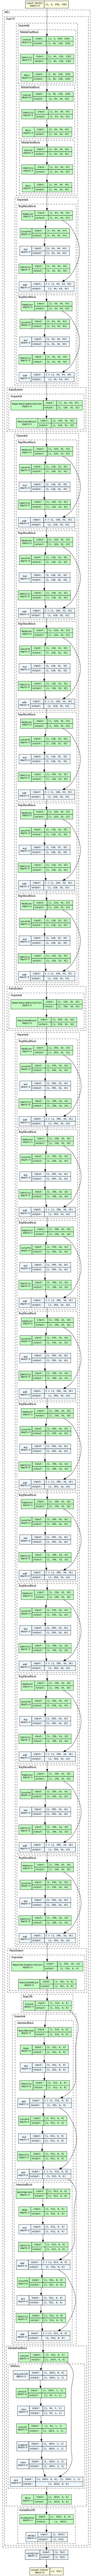

In [24]:
#Optional: Visualize the model
from torchview import draw_graph
import graphviz
graphviz.set_jupyter_format('png')
model_graph = draw_graph(reparameterized_model, input_data = image, expand_nested = True, depth = 5)
model_graph.visual_graph